# Attributions

**Emily:** All parts

**Chris:** Reviewed solution

**Naveen:** Reviewed solution

Loading BokehJS ...


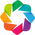

In [5]:
# Imports

import numpy as np
import pandas as pd

import bokeh.io
import bokeh.plotting
from bokeh.layouts import row

import holoviews as hv

import pymc3 as pm
import theano.tensor as tt
import theano

import bebi103
import numba

import scipy
import scipy.stats as st

import statsmodels.tools.numdiff as smnd

from IPython.display import display # Compatibility fix

bokeh.io.output_notebook()
hv.extension('bokeh')

# Part a

We will tidy the data in the same format as we did in Question 7.1(a). Everything in the data organization is already tidy except that there are duplicates for the same tagged bird in the same year. This is undesirable because it is not an accurate representation of the population of the birds in that year. We have chosen to take the average of all duplicate observations in a given year. We will NOT touch duplicates of birds in *different* years because that is a true representaiton of the bird population of the different years, and it would not make sense to remove that observation or combine them with ones from different years.

In [34]:
# Read in the beak data
mydata = pd.read_csv("../data/finch_beaks.csv", header=1)

# Grouping the data by band and year, then taking the average of any observations that 
# are from the same bird in the same year using np
grouped = mydata.groupby(["band", "year", "species"])
grouped = grouped.agg("mean")
grouped = grouped.reset_index()

# Make new np array with only unique values for each year
uniques = grouped["band"].unique()

# dataframe
grouped["band"].loc

# Display
grouped.head()

,band,year,species,beak length (mm),beak depth (mm)
0,2,1975,fortis,9.4,8.0
1,9,1975,fortis,9.2,8.3
2,12,1975,fortis,9.5,7.5
3,15,1975,fortis,9.5,8.0
4,302,1975,scandens,13.9,8.4


# Parts b & c

First, we need to use this data to fit to a model before we can do further analysis, since model comparison is the Bayesian equivalent of hypothesis testing. Because beak depth is the result of many natural subprocesses we can use the central limit theorem to hypothesize the distribution of beak depths will tend toward a Gaussian. We can also confirm this by plotting a histogram of the data.

In [3]:
# 1975 plot
p = bebi103.viz.histogram(grouped["beak depth (mm)"].loc[grouped["year"]==1975], color='#30a2da', legend="1975")

# 2012 plot
p = bebi103.viz.histogram(grouped["beak depth (mm)"].loc[grouped["year"]==2012], color='#fc4f30', legend="2012", p = p)
bokeh.io.show(p)

We can see from the histogram that this is mostly a normal distribution. Then, we will approximate the likelihood as such. For comparison, we'll use a Uniform model sampling across the same range as for the uniform (from 0 to 20, since the mean falls around 9 from eyeballing the histogram.

We will use Pymc3's MCMC to sample the two distributions. First let's split up the two groups of data we want to compare.

In [4]:
# Pull out the beak depth data 
bd_1975 = grouped['beak depth (mm)'].loc[grouped["year"]==1975].values
bd_2012 = grouped['beak depth (mm)'].loc[grouped["year"]==2012].values

Now for the models and sampling:

In [5]:
# Gaussian for 1975
with pm.Model() as beakdepth_norm_1975:
    # Priors
    mu = pm.Uniform('mu', lower=5, upper=15)
    sigma = bebi103.pm.Jeffreys('sigma', lower=0.1, upper=10)
    
    # Likelihood
    bd_obs_1975 = pm.Normal('bd_obs_1975', mu=mu, sd=sigma, observed=bd_1975)
    
    # Draw samples
    trace_norm_1975 = pm.sample(draws=10000, tune=10000, njobs=1, init='advi+adapt_diag')
    
    # Convert to data frame
    df_norm_1975 = bebi103.pm.trace_to_dataframe(trace_norm_1975, log_post=True)
    
# Gaussian for 2012
with pm.Model() as beakdepth_norm_2012:
    # Priors
    mu = pm.Uniform('mu', lower=5, upper=15)
    sigma = bebi103.pm.Jeffreys('sigma', lower=0.1, upper=10)
    
    # Likelihood
    bd_obs_2012 = pm.Normal('bd_obs_2012', mu=mu, sd=sigma, observed=bd_2012)
    
    # Draw samples
    trace_norm_2012 = pm.sample(draws=10000, tune=10000, njobs=1, init='advi+adapt_diag')
    
    # Convert to data frame
    df_norm_2012 = bebi103.pm.trace_to_dataframe(trace_norm_2012, log_post=True)

# Uniform for comparison
with pm.Model() as beakdepth_unif:
    lower = 5
    upper = 15
    
    # Likelihood
    bd_obs = pm.Uniform('bd_obs', lower=lower, upper=upper)
    
    # Draw samples
    trace_unif = pm.sample(draws=10000, tune=10000, njobs=1, init='advi+adapt_diag')
    
    # Convert to data frame
    df_unif = bebi103.pm.trace_to_dataframe(trace_unif)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...
Average Loss = 461.91:   6%|██▉                                               | 11605/200000 [00:02<00:29, 6393.85it/s]
Convergence archived at 11700
INFO:pymc3.variational.inference:Convergence archived at 11700
Interrupted at 11,699 [5%]: Average Loss = 687.11
INFO:pymc3.variational.inference:Interrupted at 11,699 [5%]: Average Loss = 687.11
100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1702.12it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...
Average Loss = 308.83:   6%|██▊                                               | 11074/200000 [00:01<00:34, 5548.36it/s]
Convergence archived at 11200
INFO:pymc3.variational.inference:Convergence

Let's plot the distributions using ECDFs comparing the sampling to the experimental data. 

In [6]:
# Generate plots    
p = bebi103.viz.ecdf(bd_1975, x_axis_label = 'Beak Depth (mm)', title = 'ECDF of MCMC Sampling for 1975 Beak Depth')

x = np.linspace(np.min(bd_1975), np.max(bd_1975), 1000)

# Plot 2012 sampling data
for _, row in df_norm_1975.loc[::1000, ['mu', 'sigma']].iterrows():
    # Add Gaussian model CDF
    p.line(x, st.norm.cdf(x, loc=row['mu'],scale=row['sigma']), line_width=0.5,
           alpha=0.15, color='tomato', legend='Gaussian')

for _, row in df_unif.loc[::1000, ['bd_obs']].iterrows():
    # Add Gaussian model CDF
    p.line(x, st.uniform.cdf(x, loc=row['bd_obs']), line_width=0.5,
           alpha=0.15, color='green', legend='Uniform')

p.legend.location='bottom_right'

bokeh.io.show(p)

I actually laughed out loud when the graph displayed on my computer because wow that uniform distribution is so bad. At least we know that's definitely not the right one. On the other hand, the Gaussian seems to fit pretty well, with a tight spread as opposed to a wide one, which is good. Let's plot the Gaussian (and ignore the uniform because now we know it's definitely not right, for reference) for 2012 as well.

In [7]:
# PLotting 2012 data
p = bebi103.viz.ecdf(bd_2012, x_axis_label = 'Beak Depth (mm)', title = 'ECDF of MCMC Sampling for 2012 Beak Depth')

x = np.linspace(np.min(bd_2012), np.max(bd_2012), 1000)

for _, row in df_norm_2012.loc[::1000, ['mu', 'sigma']].iterrows():
    # Add Gaussian model CDF
    p.line(x, st.norm.cdf(x, loc=row['mu'],scale=row['sigma']), line_width=0.5,
           alpha=0.15, color='purple', legend='Gaussian')

p.legend.location='bottom_right'

bokeh.io.show(p)

Okay nice, looking good for this as well. Now that we have two appropriate Gaussian distribution samplings for each year, we can compare the sampling results by plotting their histograms. Overlaying the histograms, we will also calculate the Bayesian equivalent of the confidence interval, which is the credible region. We'll find a 95% median HPD, which should be the shortest interval that contains 95% of the probability of the posterior. So, we report the median (the most probable parameter value) and then the bounds on the HPD interval. This is where the parameter value is most likely to fall. It also tells us the most probable parameter value (the MAP).

In [8]:
def plot_errorbar(x, y, barx, color, legend, p):
    p.circle([x], [y], size=10, color=color, legend=legend)
    p.line(barx, [y, y], line_width=4, color=color)

# 1975 data
hpd_hilo_1975 = pm.hpd(trace_norm_1975, alpha=0.05)['mu']
x_1975 = np.percentile(df_norm_1975['mu'], 50)
plots = bebi103.viz.histogram(df_norm_1975['mu'], 
                               bins=50,
                               plot_width=450,
                               plot_height=300,
                               x_axis_label='Mean Beak Depth (mm)',
                               y_axis_label='pdf',
                               title='Histogram of 1975 Beak Depth Sampling',
                               line_width=2,
                               color='gray')
plot_errorbar(x_1975, 5, hpd_hilo_1975, color='red',legend='Gaussian', p=plots)

bokeh.io.show(plots)

# HPD interval
print('1975 Beak Depth 95% HPD: [{0:.2f}, {1:.2f}] mm'.format(*pm.hpd(df_norm_1975['mu'], 0.95)))
print('1975 Beak Depth median:', x_1975)

1975 Beak Depth 95% HPD: [9.12, 9.13] mm
1975 Beak Depth median: 9.12207546682


I can't run the gridplot on Windows for some reason it just totally screws up so here's another code cell.

In [9]:
hpd_hilo_2012 = pm.hpd(trace_norm_2012, alpha=0.05)['mu']
x_2012 = np.percentile(df_norm_2012['mu'], 50)
plots = bebi103.viz.histogram(df_norm_2012['mu'], 
                               bins=50,
                               plot_width=450,
                               plot_height=300,
                               x_axis_label='Mean Beak Depth (mm)',
                               y_axis_label='pdf',
                               title='Histogram of 2012 Beak Depth Sampling',
                               line_width=2,
                               color='gray')
# Median with HPD
plot_errorbar(x_2012, 5, hpd_hilo_2012, color='red',legend='Gaussian', p=plots)
bokeh.io.show(plots)
print('2012 Beak Depth 95% HPD: [{0:.2f}, {1:.2f}] mm'.format(*pm.hpd(df_norm_2012['mu'], 0.95)))
print('2012 Beak Depth median:', x_2012)

2012 Beak Depth 95% HPD: [8.90, 8.90] mm
2012 Beak Depth median: 8.90277541503


Comparing the median of each year, we can see it shifted from 9.12 mm in 1975 to 8.90 mm in 2012. This certainly a noticeable change in beak depth, considering if you look at the spread of each Gaussian from the two years they hardly overlap at all (the max beak depth of the 2012 Gaussian sampling is around 9.1 mm). It would seem that the beak depth has decreased over time. This might have been due to the drought that was mentioned in the problem statement. Maybe smaller birds with smaller beaks were more adept at surviving in drier conditions because they needed less water. Or perhaps smaller beak depth allowed birds to fit their beaks into crevices/unusual places that had water, which allowed them to stay hydrated compared to their counterparts with bigger beaks.

<div class="alert alert-info">
Very good, but you did not have to so much work to find the CI! With the Bayesian treatment, we assume that the mean beak length is Gaussian distributed so to find the mean/sd, we can exploit the analytical expression for the mean and sd so no need to do the whole mcmc sampling. Using this mean and sd, you can directly calculate the 95% CI as 1.96 sd's on either side of the mean. This is the real advantage of asusming a Gaussian. Without this assumption, one needs to sample and then fidn the 95% CI (as covering 0.95 of the area uder the curve). 2/2

As for the hypothesis test, you are correct that it is indeed a model selection problem in the Bayesian setting. To quantitatively compare the two hypothesis (models), you want to calculate the odds ratio using the posteriors you have sampled out of above. Otherwise it is all fine. 7/12
</div>

# Part d

We saw in 7.1(d) that between the two possible metrics for beak shape of PCA vs. length/depth, the length/depth comparison gave us more noticeable trends, so we'll use the information we found from the frequentist data (which goes to show it can be useful to use frequentist analysis also, and fit to a model to see compatibility after!) to infer that we can fit the length/depth data to a bimodal distribution, aka two Gaussians. Let's remind ourselves of this data set said.

In [31]:
# Organizing and extracting the desired beak measurements
years = [1973, 1975, 1987, 1991, 2012]
colors = bokeh.palettes.brewer['Spectral'][5]

beaks_years = ([grouped.loc[grouped['year'] == year, ['beak length (mm)', 'beak depth (mm)']].values
                     for year in years])

beaks_years_fat = ([data.T[0] / data.T[1] for data in beaks_years])


p2 = bokeh.plotting.figure(plot_height=400,
                           plot_width=400,
                           x_axis_label='Non-linear combination (length/depth)')
p2.y_range = bokeh.models.Range1d(-5, 5)
p2.background_fill_color = "black"
p2.background_fill_alpha = 0.2

for index, data in enumerate(beaks_years_fat):
    
    p2.circle(data,
              0.2*index*np.ones(len(data)),
              color=colors[index],
              legend=str(years[index]))
    
bokeh.io.show(p2)

Now let's start the sampling process.

In [49]:
# Create new length/width column for our calculations
grouped['length/width'] = grouped['beak length (mm)']/grouped['beak depth (mm)']
grouped.head()

,band,year,species,beak length (mm),beak depth (mm),length/width
0,2,1975,fortis,9.4,8.0,1.175000
1,9,1975,fortis,9.2,8.3,1.108434
2,12,1975,fortis,9.5,7.5,1.266667
3,15,1975,fortis,9.5,8.0,1.187500
4,302,1975,scandens,13.9,8.4,1.654762


# Warning, this next cell takes a while to run, perhaps increase njobs if your computer can handle it.

In [88]:
for i in range(len(years)):
    bd = grouped['length/width'].loc[grouped["year"]==years[i]].values

    # Single Gaussian
    with pm.Model() as single_norm:
        # Priors
        mu = pm.Uniform('mu', lower=0, upper=2)
        sigma = bebi103.pm.Jeffreys('sigma', lower=0.1, upper=2)

        # Likelihood
        bd_obs = pm.Normal('bd_obs', mu=mu, sd=sigma, observed=bd)

        # Draw samples
        trace_norm = pm.sample(draws=10000, tune=10000, njobs=1, init='advi+adapt_diag')

        # Convert to data frame
        df_norm = bebi103.pm.trace_to_dataframe(trace_norm, log_post=True)
    
    plots = []
    plots.append(bebi103.viz.histogram(df_norm['mu'], 
                               bins=50,
                               plot_width=350,
                               plot_height=250,
                               x_axis_label='length/width',
                               y_axis_label='pdf',
                               title='Single Gaussian',
                               line_width=2,
                               color='gray'))
    plots[0] = bebi103.viz.histogram(bd, bins=50,
                               plot_width=350,
                               plot_height=250,
                               x_axis_label='length/width',
                               y_axis_label='pdf', p=plots[0])
    
    # Two Gaussians
    with pm.Model() as two_norms:
        # Priors
        mu1 = pm.Uniform('mu1', lower=0, upper=2)
        sigma1 = bebi103.pm.Jeffreys('sigma1', lower=0.1, upper=2)

        mu2 = pm.Uniform('mu2', lower=0, upper=2)
        sigma2 = bebi103.pm.Jeffreys('sigma2', lower=0.1, upper=2)

        bd_dist1 = pm.Normal.dist(mu=mu1, sd=sigma1)
        bd_dist2 = pm.Normal.dist(mu=mu2, sd=sigma2)

        bd_obs = pm.Mixture('bd_obs', [0.5, 0.5], [bd_dist1, bd_dist2], observed=bd)

        trace_two_norms = pm.sample(draws=20000, tune=5000)

        df_two_norms = bebi103.pm.trace_to_dataframe(trace_two_norms, log_post=True)
        
    m1 = df_two_norms['mu1'];
    m2 = df_two_norms['mu2'];
    mu12 = pd.concat([m1,m2], ignore_index = True)
    
    plots.append(bebi103.viz.histogram(mu12, 
                               bins=50,
                               plot_width=350,
                               plot_height=250,
                               x_axis_label='x',
                               y_axis_label='pdf',
                               title='Two Gaussians',
                               line_width=2,
                               color='gray'))
    plots[1]= bebi103.viz.histogram(bd, bins=50,
                               plot_width=350,
                               plot_height=250,
                               x_axis_label='length/width',
                               y_axis_label='pdf', p=plots[1])
    
    bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=2))

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...
Average Loss = -14.179:   5%|██▍                                               | 9531/200000 [00:01<00:30, 6162.61it/s]
Convergence archived at 9700
INFO:pymc3.variational.inference:Convergence archived at 9700
Interrupted at 9,699 [4%]: Average Loss = 13.004
INFO:pymc3.variational.inference:Interrupted at 9,699 [4%]: Average Loss = 13.004
100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1631.31it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:36<00:00, 689.84it/s]


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...
Average Loss = -68.378:   5%|██▍                                               | 9554/200000 [00:01<00:27, 6804.90it/s]
Convergence archived at 10100
INFO:pymc3.variational.inference:Convergence archived at 10100
Interrupted at 10,099 [5%]: Average Loss = 54.65
INFO:pymc3.variational.inference:Interrupted at 10,099 [5%]: Average Loss = 54.65
100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1772.04it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████████████████████████████████████████████████████████████████████▉| 24996/25000 [00:43<00:00, 607.73it/s]C:\Users\emily\Anaconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...
Average Loss = -338.97:   6%|██▋                                              | 11217/200000 [00:02<00:31, 6038.05it/s]
Convergence archived at 11700
INFO:pymc3.variational.inference:Convergence archived at 11700
Interrupted at 11,699 [5%]: Average Loss = -1.5599
INFO:pymc3.variational.inference:Interrupted at 11,699 [5%]: Average Loss = -1.5599
100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1770.70it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████████████████████████████████████████████████████████████████████▊| 24953/25000 [00:55<00:00, 545.89it/s]C:\Users\emily\Anaconda3\lib\site-packages\pymc3\step_methods\hmc\nut

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...
Average Loss = -228.74:   5%|██▋                                              | 10751/200000 [00:01<00:29, 6321.01it/s]
Convergence archived at 10900
INFO:pymc3.variational.inference:Convergence archived at 10900
Interrupted at 10,899 [5%]: Average Loss = 10.462
INFO:pymc3.variational.inference:Interrupted at 10,899 [5%]: Average Loss = 10.462
100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:13<00:00, 1535.11it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████████████████████████████████████████████████████████████████████▉| 24987/25000 [01:07<00:00, 402.79it/s]C:\Users\emily\Anaconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...
Average Loss = -96.051:   5%|██▌                                              | 10475/200000 [00:01<00:34, 5464.39it/s]
Convergence archived at 10500
INFO:pymc3.variational.inference:Convergence archived at 10500
Interrupted at 10,499 [5%]: Average Loss = 15.661
INFO:pymc3.variational.inference:Interrupted at 10,499 [5%]: Average Loss = 15.661
100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1608.97it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:45<00:00, 549.40it/s]


Whoops, at the end there the models got progressively sharper and stopped matching the distributions as much...I think it's a scaling issue I could fix if I had time/the computer power to do so but running these 5 alone took 10 minutes so I'm just going to explain what we see above.

The graphs are in the appropriate sequence time order, so the first pair is the earliest (1973) and the last pair of graphs is the most recent (2012).

We notice from the sampling of single and double Gaussians that in 1973, the two-Gaussian model fits the real data better, with two noticeable clumps in the experimental data (the mu ~= 1.1 for one of the two Gaussian peaks is really spot on!). However, as we progress toward 1987, we stop seeing this bimodal behavior in the experimental data and the two-gaussian model stops being as predictive. Rather, we start to see one very shallow peak, fitting the single Gaussian more closely. Finally, in 2012, the peak of the experimental data is not very distinct, but if you zoom in closely you can tell it definitely is no longer properly fitted using two gaussians at all, and it's slightly closer to a single gaussian model. This confirms what we saw in the frequentist method such that the two distinct species originally existed with different length/width characteristics, but over time they changed to become more similar.

<div class="alert alert-info">
Good; see previous comment regarding findign mean/CI for a Gaussian. 2/2
</div>

# Part e

Let's compute a credible region for this stuff instead of confidence interval.

In [11]:
# Read in data
df_herd_f = pd.read_csv('../data/fortis_beak_depth_heredity.csv', comment='#')
df_herd_s = pd.read_csv('../data/scandens_beak_depth_heredity.csv', comment='#')

df_herd_f['mid_parent'] = df_herd_f[['Male BD', 'Female BD']].mean(axis=1)

# Convert to numpy arrays where we have data in the form of [parents, children]
herd_f = df_herd_f[['mid_parent', 'Mid-offspr']].values.T
herd_s = df_herd_s[['mid_parent', 'mid_offspring']].values.T

# Now define a function to help with finding the heritability/cov

# First we need to modify our bootstrap sampling function
@numba.jit(nopython=True)
def draw_bs_sample(data):
    return data[np.random.choice(len(data), size=len(data)), :]

#@numba.jit(nopython=True) # Not sure why numba doesn't play well with np.cov
def draw_bs_reps_herd(data, size=10000):
    out = np.empty(size)
    for i in range(size):
        covar = np.cov(draw_bs_sample(data.T).T)
        out[i] = covar[0, 1] / covar[0, 0]
    return out

f_reps = draw_bs_reps_herd(herd_f)
s_reps = draw_bs_reps_herd(herd_s)

In [14]:
# HPD interval
print('G. fortis 95% HPD: [{0:.2f}, {1:.2f}] mm'.format(*pm.hpd(f_reps, 0.95)))
print('G. fortis median:', np.median(f_reps))

print('G. scandens 95% HPD: [{0:.2f}, {1:.2f}] mm'.format(*pm.hpd(s_reps, 0.95)))
print('G. scandens median:', np.median(s_reps))

G. fortis 95% HPD: [0.74, 0.74] mm
G. fortis median: 0.7241502162
G. scandens 95% HPD: [0.53, 0.55] mm
G. scandens median: 0.548122447478


<div class="alert alert-info">
The last part was to study the heritability in the Bayesian setting; to do this you can treat the parent and offspring relationship as a multivariate Gaussian. 
</div>

<div class="alert alert-info">
Very good overall! 11/20
</div>